In [1]:
import os
#os.environ["JAX_PLATFORMS"] = "cpu"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=128"

In [2]:
import jax
import jax.numpy as jnp
import NNjax
import h5py
import json
import time
import numpy
import pyccl
import scipy
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.lines as mlines
import multiprocessing
import psutil
import threading

In [3]:
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
synthesize_folder = os.path.join(folder, 'SYNTHESIZE/')

tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NN'

os.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)
os.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)

In [4]:
# Load
with h5py.File(os.path.join(synthesize_folder, '{}/{}_{}.hdf5'.format(tag, typ, label)), 'r') as file:
    data_lens = file['lens']['data'][...]
data_size, bin_lens_size, z_size = data_lens.shape

# Galaxy
with open(os.path.join(info_folder, 'GALAXY.json'), 'r') as file:
    galaxy_info = json.load(file)

In [5]:
# Redshift
z1 = 0.0
z2 = 3.0
z_grid = numpy.linspace(z1, z2, z_size)

In [6]:
# Cosmology
with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    cosmology_info = json.load(file)

Omega_m = cosmology_info['OMEGA_M']

cosmology = pyccl.Cosmology(
    h=cosmology_info['H'],
    w0=cosmology_info['W0'],
    wa=cosmology_info['WA'],
    n_s=cosmology_info['NS'], 
    A_s=cosmology_info['AS'], 
    m_nu=cosmology_info['M_NU'],
    Neff=cosmology_info['N_EFF'],
    Omega_k=cosmology_info['OMEGA_K'], 
    Omega_b=cosmology_info['OMEGA_B'], 
    Omega_c=cosmology_info['OMEGA_CDM'],
    Omega_g=cosmology_info['OMEGA_GAMMA'], 
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

    
pyccl.spline_params.N_K = z_size
pyccl.gsl_params.NZ_NORM_SPLINE_INTEGRATION = True

In [7]:
# Multipole
ell1 = 20
ell2 = 2000
ell_size = 20
ell_grid = numpy.geomspace(ell1, ell2, ell_size + 1)
ell_data = numpy.sqrt(ell_grid[+1:] * ell_grid[:-1])

LENS_PSI_GRID = numpy.mean(data_lens, axis = 0)
LENS_SIGMA_GRID = numpy.std(data_lens, axis = 0)
A_GRID = numpy.array(1 / (1 + z_grid), dtype = 'double')

CHI_GRID = cosmology.comoving_radial_distance(a = A_GRID)
LENS_PHI_GRID = LENS_PSI_GRID * cosmology.h_over_h0(a = 1 / (1 + z_grid)) * cosmology_info['H'] * 100000 / scipy.constants.c

CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ell_grid)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ell_size + 1, z_size)) + numpy.inf, where = CHI_MESH > 0))
POWER_GRID = numpy.zeros((ell_size + 1, z_size))
for GRID_INDEX in range(z_size):

    POWER_GRID[:,GRID_INDEX] = cosmology.nonlin_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])
AMPLITUDE = 1

In [8]:
# Define the angular power spectrum

def c_m1_m2_NN(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, redshift_grid, type):

    pgg = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
    
    phi_m1 = scipy.interpolate.interp1d(chi_grid, phi_m1_grid, kind = type)
    
    phi_m2 = scipy.interpolate.interp1d(chi_grid, phi_m2_grid, kind = type)
    
    function = lambda chi: phi_m1(chi) * phi_m2(chi) * pgg(chi) / (chi**2)
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

In [9]:
#Angular power Spectra(CCL)
C_CCL = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))
C_DATA1 = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))
C_DATA2 = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))
C_DATA3 = numpy.zeros((bin_lens_size, bin_lens_size, ell_size+1))

g_b = numpy.asarray(galaxy_info[tag])
POWER_GRID_bias = POWER_GRID * g_b *g_b

T_pyccl=0
for (i, j) in product(range(bin_lens_size), range(bin_lens_size)):
    T0 = time.time()
    tracer1 = pyccl.tracers.NumberCountsTracer(cosmo=cosmology, dndz=[z_grid, LENS_PSI_GRID[i, :]], bias=[z_grid, galaxy_info[tag]], mag_bias=None, has_rsd=False, n_samples=z_size)
    tracer2 = pyccl.tracers.NumberCountsTracer(cosmo=cosmology, dndz=[z_grid, LENS_PSI_GRID[j, :]], bias=[z_grid, galaxy_info[tag]], mag_bias=None, has_rsd=False, n_samples=z_size)
    C_CCL[i, j,:] = pyccl.cells.angular_cl(cosmo=cosmology, tracer1=tracer1, tracer2=tracer2, ell=ell_grid, p_of_k_a='delta_matter:delta_matter', l_limber=-1, limber_max_error=0.01, limber_integration_method='qag_quad', non_limber_integration_method='FKEM', fkem_chi_min=0, fkem_Nchi=z_size, p_of_k_a_lin='delta_matter:delta_matter', return_meta=False)
    T1 = time.time()
    T_pyccl=T_pyccl+T1-T0  

    for ELL_INDEX in range(ell_size + 1):
        
        C_DATA1[i, j, ELL_INDEX] = c_m1_m2_NN(amplitude =AMPLITUDE, phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = LENS_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_bias[ELL_INDEX,:], redshift_grid = z_grid, type = 'slinear')
        C_DATA2[i, j, ELL_INDEX] = c_m1_m2_NN(amplitude =AMPLITUDE, phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = LENS_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_bias[ELL_INDEX,:], redshift_grid = z_grid, type = 'quadratic')
        C_DATA3[i, j, ELL_INDEX] = c_m1_m2_NN(amplitude =AMPLITUDE, phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = LENS_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_bias[ELL_INDEX,:], redshift_grid = z_grid, type = 'cubic')
        
    T2 = time.time()
    print(i, j, T1 - T0, T2 - T1)

print('pyccl calculation time for NN:%fs' %T_pyccl)

0 0 0.00656437873840332 0.18158864974975586
0 1 0.0044558048248291016 0.03612494468688965
0 2 0.0009758472442626953 0.037018537521362305
0 3 0.0008387565612792969 0.03584098815917969
0 4 0.0008285045623779297 0.03532147407531738
1 0 0.004171848297119141 0.03540492057800293
1 1 0.004901409149169922 0.03870725631713867
1 2 0.003520488739013672 0.035581350326538086
1 3 0.003239870071411133 0.03336596488952637
1 4 0.0032300949096679688 0.03469133377075195
2 0 0.0006990432739257812 0.03345680236816406
2 1 0.0029883384704589844 0.03361701965332031
2 2 0.003563404083251953 0.035105228424072266
2 3 0.002747774124145508 0.033468008041381836
2 4 0.006615400314331055 0.03517961502075195
3 0 0.0007891654968261719 0.03464388847351074
3 1 0.0031256675720214844 0.032835960388183594
3 2 0.002597332000732422 0.03457951545715332
3 3 0.005964040756225586 0.03400135040283203
3 4 0.003990888595581055 0.03311634063720703
4 0 0.0006973743438720703 0.03507733345031738
4 1 0.002988576889038086 0.03438663482666

In [10]:
def test_nn_jax(AMPLITUDE, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID, Galaxy_bias, REDSHIFT_GRID):
    # Get the total number of CPU cores
    total_cpu_count = multiprocessing.cpu_count()
    print(f"Total available CPU cores: {total_cpu_count}")

    # Usage of CPU 
    samples = []
    stop_evt = threading.Event()
    def sampler():
        while not stop_evt.is_set():
            samples.append(psutil.cpu_percent(interval=None, percpu=True))
            time.sleep(0.1)

    t = threading.Thread(target=sampler)
    t.start()

    start_time = time.time()
    g_b = numpy.asarray(Galaxy_bias)
    POWER_GRID_bias = POWER_GRID * g_b *g_b
    

    PHI_GRID1 = jnp.array(PHI_GRID1)
    PHI_GRID2 = jnp.array(PHI_GRID2)
    CHI_GRID = jnp.array(CHI_GRID)
    POWER_GRID_bias = jnp.array(POWER_GRID_bias)
    REDSHIFT_GRID = jnp.array(REDSHIFT_GRID)


    # Run the NNjax function
    result=NNjax.function(AMPLITUDE, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID_bias, REDSHIFT_GRID)  

    end_time = time.time()
    print(f"NNjax execution time: {end_time - start_time} seconds")
    
    stop_evt.set()
    t.join()
    arr = numpy.array(samples)  # shape: (n_samples, n_cores)
    mean_per_core = arr.mean(axis=0)
    active_cores = (mean_per_core > 5).sum()
    print(f"Average number of active cores：{active_cores}/{total_cpu_count}")
    print(f"Average utilization per core：{numpy.round(mean_per_core, 1)}")
    
    return result


C_DATA = numpy.array(test_nn_jax(AMPLITUDE, LENS_PHI_GRID, LENS_PHI_GRID, CHI_GRID, POWER_GRID,galaxy_info[tag], z_grid))

Total available CPU cores: 256
NNjax execution time: 3.3708646297454834 seconds
Average number of active cores：108/256
Average utilization per core：[36.3 12.6 15.5 14.9  2.1  4.1  0.9  2.7 17.7  4.9  7.3  1.9 10.4 16.3
  4.6  6.3  7.   3.6  4.5  0.6  2.5  8.8  0.3  3.  10.6  0.3  0.8  0.
  0.7  0.1  0.   0.   9.1  3.4  5.   0.3  0.  28.5  1.6  4.9 99.2  9.1
  0.   0.   0.   0.   0.   0.3  8.  27.1  4.9 30.   1.1  2.9  0.7  6.2
 66.4 13.   1.6  1.8  0.5  7.7  0.1  1.3  4.2 93.   4.7  6.5  5.8  4.9
  7.8 16.3  1.7 11.8  5.3 95.5  6.3  1.6  0.6  4.6 42.9  1.  17.8  2.2
  5.8  5.8  3.2  1.4  3.9  7.1  3.2 17.2  0.8 68.5  0.7 49.2  9.2 10.3
  2.8  1.1  2.7  2.1  2.4  1.6 19.2  8.4  5.   0.6  8.5  1.7  0.3  4.6
 26.3 90.5 43.9  5.4  6.3  0.   1.   3.2 13.3  7.6  0.5 85.4  0.6  1.9
 35.  12.2  4.4 27.2 17.4 13.4 12.5  3.7 10.2  6.8 11.9  0.   8.5 16.9
  7.3 22.2  2.7  9.7 17.3  3.1 54.2  2.   1.2 88.7  0.3  3.3  3.8 22.7
  0.5  0.4  0.7  0.3  1.8  8.6  8.6  1.7  0.3 12.8  0.3 29.2 83.2  1.6
 

In [11]:
#Calculate the difference
C_RATIO = numpy.divide(C_DATA, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO1 = numpy.divide(C_DATA1, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO2 = numpy.divide(C_DATA2, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO3 = numpy.divide(C_DATA3, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)

In [12]:
print(C_RATIO)

[[[0.99281047 0.99304368 0.99310078 0.99285474 0.99291046 0.99361082
   0.9931254  0.99342227 0.99339934 0.99343672 0.99324658 0.99327227
   0.9931501  0.99307042 0.99300938 0.99297536 0.99297698 0.99301387
   0.99308415 0.9931837  0.99330185]
  [1.03697315 1.03703991 1.03711113 1.03715616 1.03716636 1.03716404
   1.03717639 1.03728225 1.03741463 1.03710567 1.03733195 1.03759656
   1.03743089 1.03729498 1.03718273 1.0371637  1.03714155 1.03713124
   1.03713388 1.03714938 1.03717627]
  [1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.        ]
  [1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.        ]
  [1.         1.         1.         1.         1.         1.
   1.      

In [13]:
print(C_RATIO1)

[[[0.99234171 0.99260044 0.99266369 0.99239997 0.99246075 0.99323187
   0.99271903 0.99301731 0.99300158 0.99305105 0.99282999 0.9928537
   0.99272116 0.99263239 0.99256421 0.99252685 0.99252997 0.99257304
   0.99265363 0.99276684 0.99290061]
  [1.03573625 1.03576937 1.03580748 1.03583499 1.03586096 1.03587092
   1.03582314 1.03589065 1.03609743 1.03569827 1.03599866 1.03624288
   1.0360774  1.03596125 1.03586265 1.035855   1.03583998 1.0358313
   1.03582977 1.03583597 1.03584925]
  [1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.        ]
  [1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.         1.         1.         1.
   1.         1.         1.        ]
  [1.         1.         1.         1.         1.         1.
   1.        

In [14]:
# Bin
with h5py.File(os.path.join(model_folder, '{}/TARGET/DATA0.hdf5'.format(tag)), 'r') as file:
    bin_lens = file['bin_lens'][...]
    bin_source = file['bin_source'][...]

bin_lens_size = len(bin_lens) - 1
bin_source_size = len(bin_source) - 1

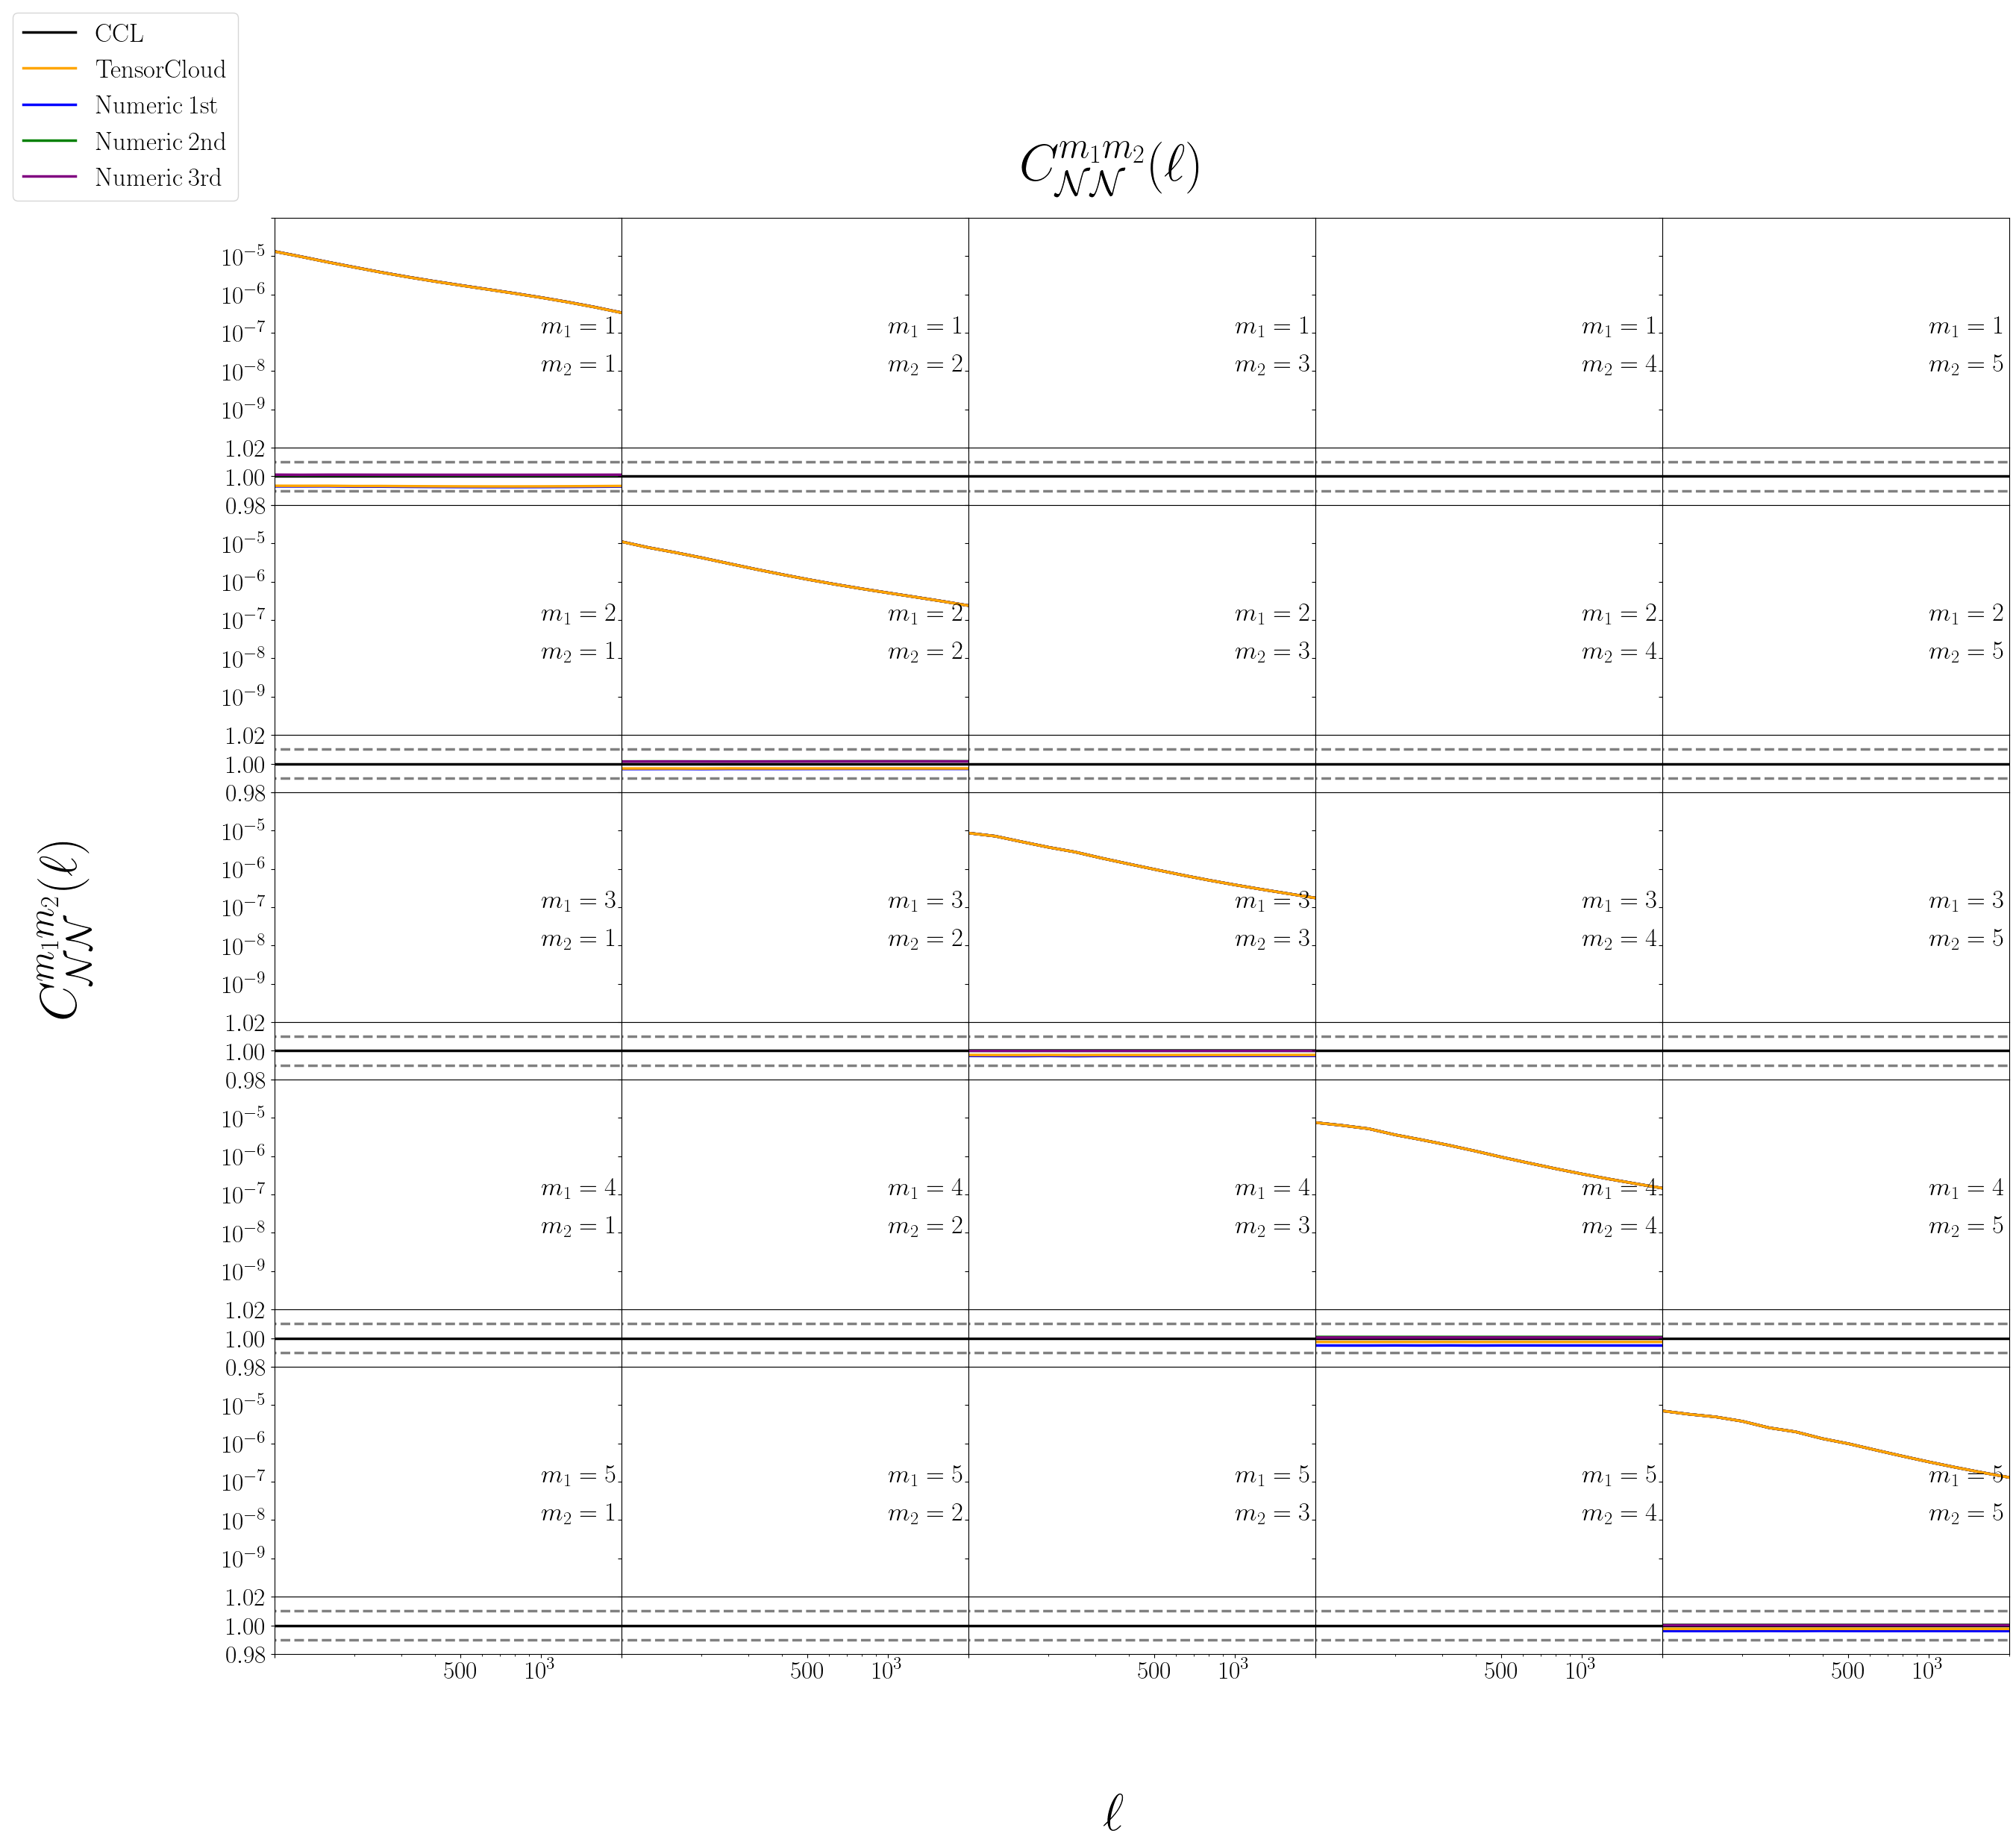

In [15]:
#Compare different bins

pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_lens_size * 6, bin_lens_size * 5))
GRIDSPEC = GridSpec(5 * bin_lens_size, 6 * bin_lens_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)
for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_lens_size), range(bin_lens_size)):
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[5 * BIN_INDEX1: 5 * BIN_INDEX1 + 4, 6 * BIN_INDEX2: 6 * BIN_INDEX2 + 6])

    if BIN_INDEX1 == BIN_INDEX2:

        PLOT.plot(ell_grid, C_CCL[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')
    
        PLOT.plot(ell_grid, C_DATA1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')
    
        PLOT.plot(ell_grid, C_DATA2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')
        
        PLOT.plot(ell_grid, C_DATA3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')
    
        PLOT.plot(ell_grid, C_DATA[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

    PLOT.text(x = 10**3, y = 10**-7, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

    PLOT.text(x = 10**3, y = 10**-8, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    
    PLOT.set_ylim(10**-10, 10**-4)
    PLOT.yaxis.set_major_locator(FixedLocator([10**-4,10**-5, 10**-6, 10**-7, 10**-8, 10**-9]))
    PLOT.yaxis.set_major_formatter(FixedFormatter([r'',r'${10}^{-5}$', r'${10}^{-6}$', r'${10}^{-7}$', r'${10}^{-8}$', r'${10}^{-9}$']))
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5 + 4: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1), color = 'black', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    if BIN_INDEX1 == BIN_INDEX2:

        PLOT.plot(ell_grid, C_RATIO1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)
    
        PLOT.plot(ell_grid, C_RATIO2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid, C_RATIO3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.98, 1.02)
    PLOT.xaxis.set_major_locator(FixedLocator([100, 500, 1000, 5000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'', r'$500$', r'${10}^3$', r'$5000$']))
    if BIN_INDEX1 < bin_lens_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{NN} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{NN} (\ell)$', fontsize = 50)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.show()

In [16]:
#Rebinning
def compute_cell_block(cell_grid, ell_grid):
    N_bin1 = cell_grid.shape[0]
    N_bin2 = cell_grid.shape[1]
    N_ell = cell_grid.shape[2]
    
    log_ell = numpy.log(ell_grid)
    normalized_grid = numpy.zeros((N_bin1, N_bin2, N_ell - 1))  
    new_ell_grid = 0.5 * (ell_grid[:-1] + ell_grid[1:])

    for i in range(N_bin1):
        for j in range(N_bin2):
            y = ell_grid * cell_grid[i, j, :]
            spline = scipy.interpolate.CubicSpline(x=log_ell, y=y, bc_type='natural', extrapolate=True)

            for k in range(N_ell - 1):
                log_lmin = numpy.log(ell_grid[k])
                log_lmax = numpy.log(ell_grid[k + 1])
                delta_ell = ell_grid[k + 1] - ell_grid[k]

                val = spline.integrate(log_lmin, log_lmax) / delta_ell
                normalized_grid[i, j, k] = val

    return normalized_grid,new_ell_grid




C_CCL_rebinned, ell_grid_rebinned=compute_cell_block(C_CCL, ell_grid)
C_DATA_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA, ell_grid)
C_DATA1_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA1, ell_grid)
C_DATA2_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA2, ell_grid)
C_DATA3_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA3, ell_grid)
C_RATIO_rebinned = numpy.divide(C_DATA_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO1_rebinned = numpy.divide(C_DATA1_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO2_rebinned = numpy.divide(C_DATA2_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO3_rebinned = numpy.divide(C_DATA3_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)

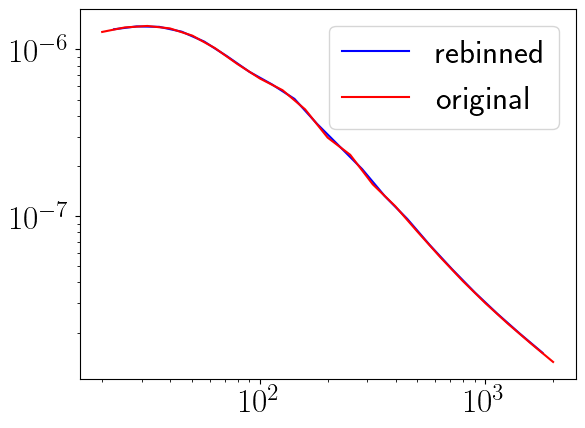

In [17]:
import matplotlib.pyplot as plt
plt.plot(ell_grid_rebinned,C_CCL_rebinned[3][2], color = 'blue',label='rebinned')
plt.plot(ell_grid,C_CCL[3][2], color = 'red',label='original')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [18]:
#diagonal covariance
k_maximal_lens = 0.1 * cosmology_info['H']
ell_maximal_lens = k_maximal_lens * pyccl.comoving_radial_distance(cosmo=cosmology, a=1 / (1 + bin_lens)) - 1 / 2

# Covariance
cell_range1 = 0
cell_range2 = bin_lens_size * (bin_lens_size + 1) // 2 * ell_size

covariance = numpy.loadtxt(os.path.join(cell_folder, '{}/COVARIANCE/COVARIANCE_MATRIX_{}.ascii'.format(tag, label)), dtype=numpy.float32)
variance = numpy.diagonal(covariance, axis1=0, axis2=1)
sigma = numpy.sqrt(variance)[cell_range1: cell_range2]



sigma_matrix = numpy.zeros((bin_lens_size, bin_lens_size, ell_size))
idx = 0
for m in range(bin_lens_size):
    for n in range(m, bin_lens_size):
        seg = sigma[idx*ell_size:(idx+1)*ell_size]    
        sigma_matrix[m, n, :] = seg
        sigma_matrix[n, m, :] = seg
        idx += 1
cell_DATA_zeta = numpy.divide(numpy.abs(C_DATA_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA1_zeta = numpy.divide(numpy.abs(C_DATA1_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA2_zeta = numpy.divide(numpy.abs(C_DATA2_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA3_zeta = numpy.divide(numpy.abs(C_DATA3_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)

In [19]:
#redshift variance
with h5py.File(os.path.join(cell_folder, '{}/{}/{}_DATA_{}.hdf5'.format(tag, name, typ, label)), 'r') as file:
    cell_data = file['data'][...]
cell_data_error = numpy.std(cell_data, axis = 0)
#sigma_all = sigma_matrix + cell_data_error 
sigma_all = numpy.sqrt(sigma_matrix**2 + cell_data_error**2)# /sqrt(a^2+b^2)

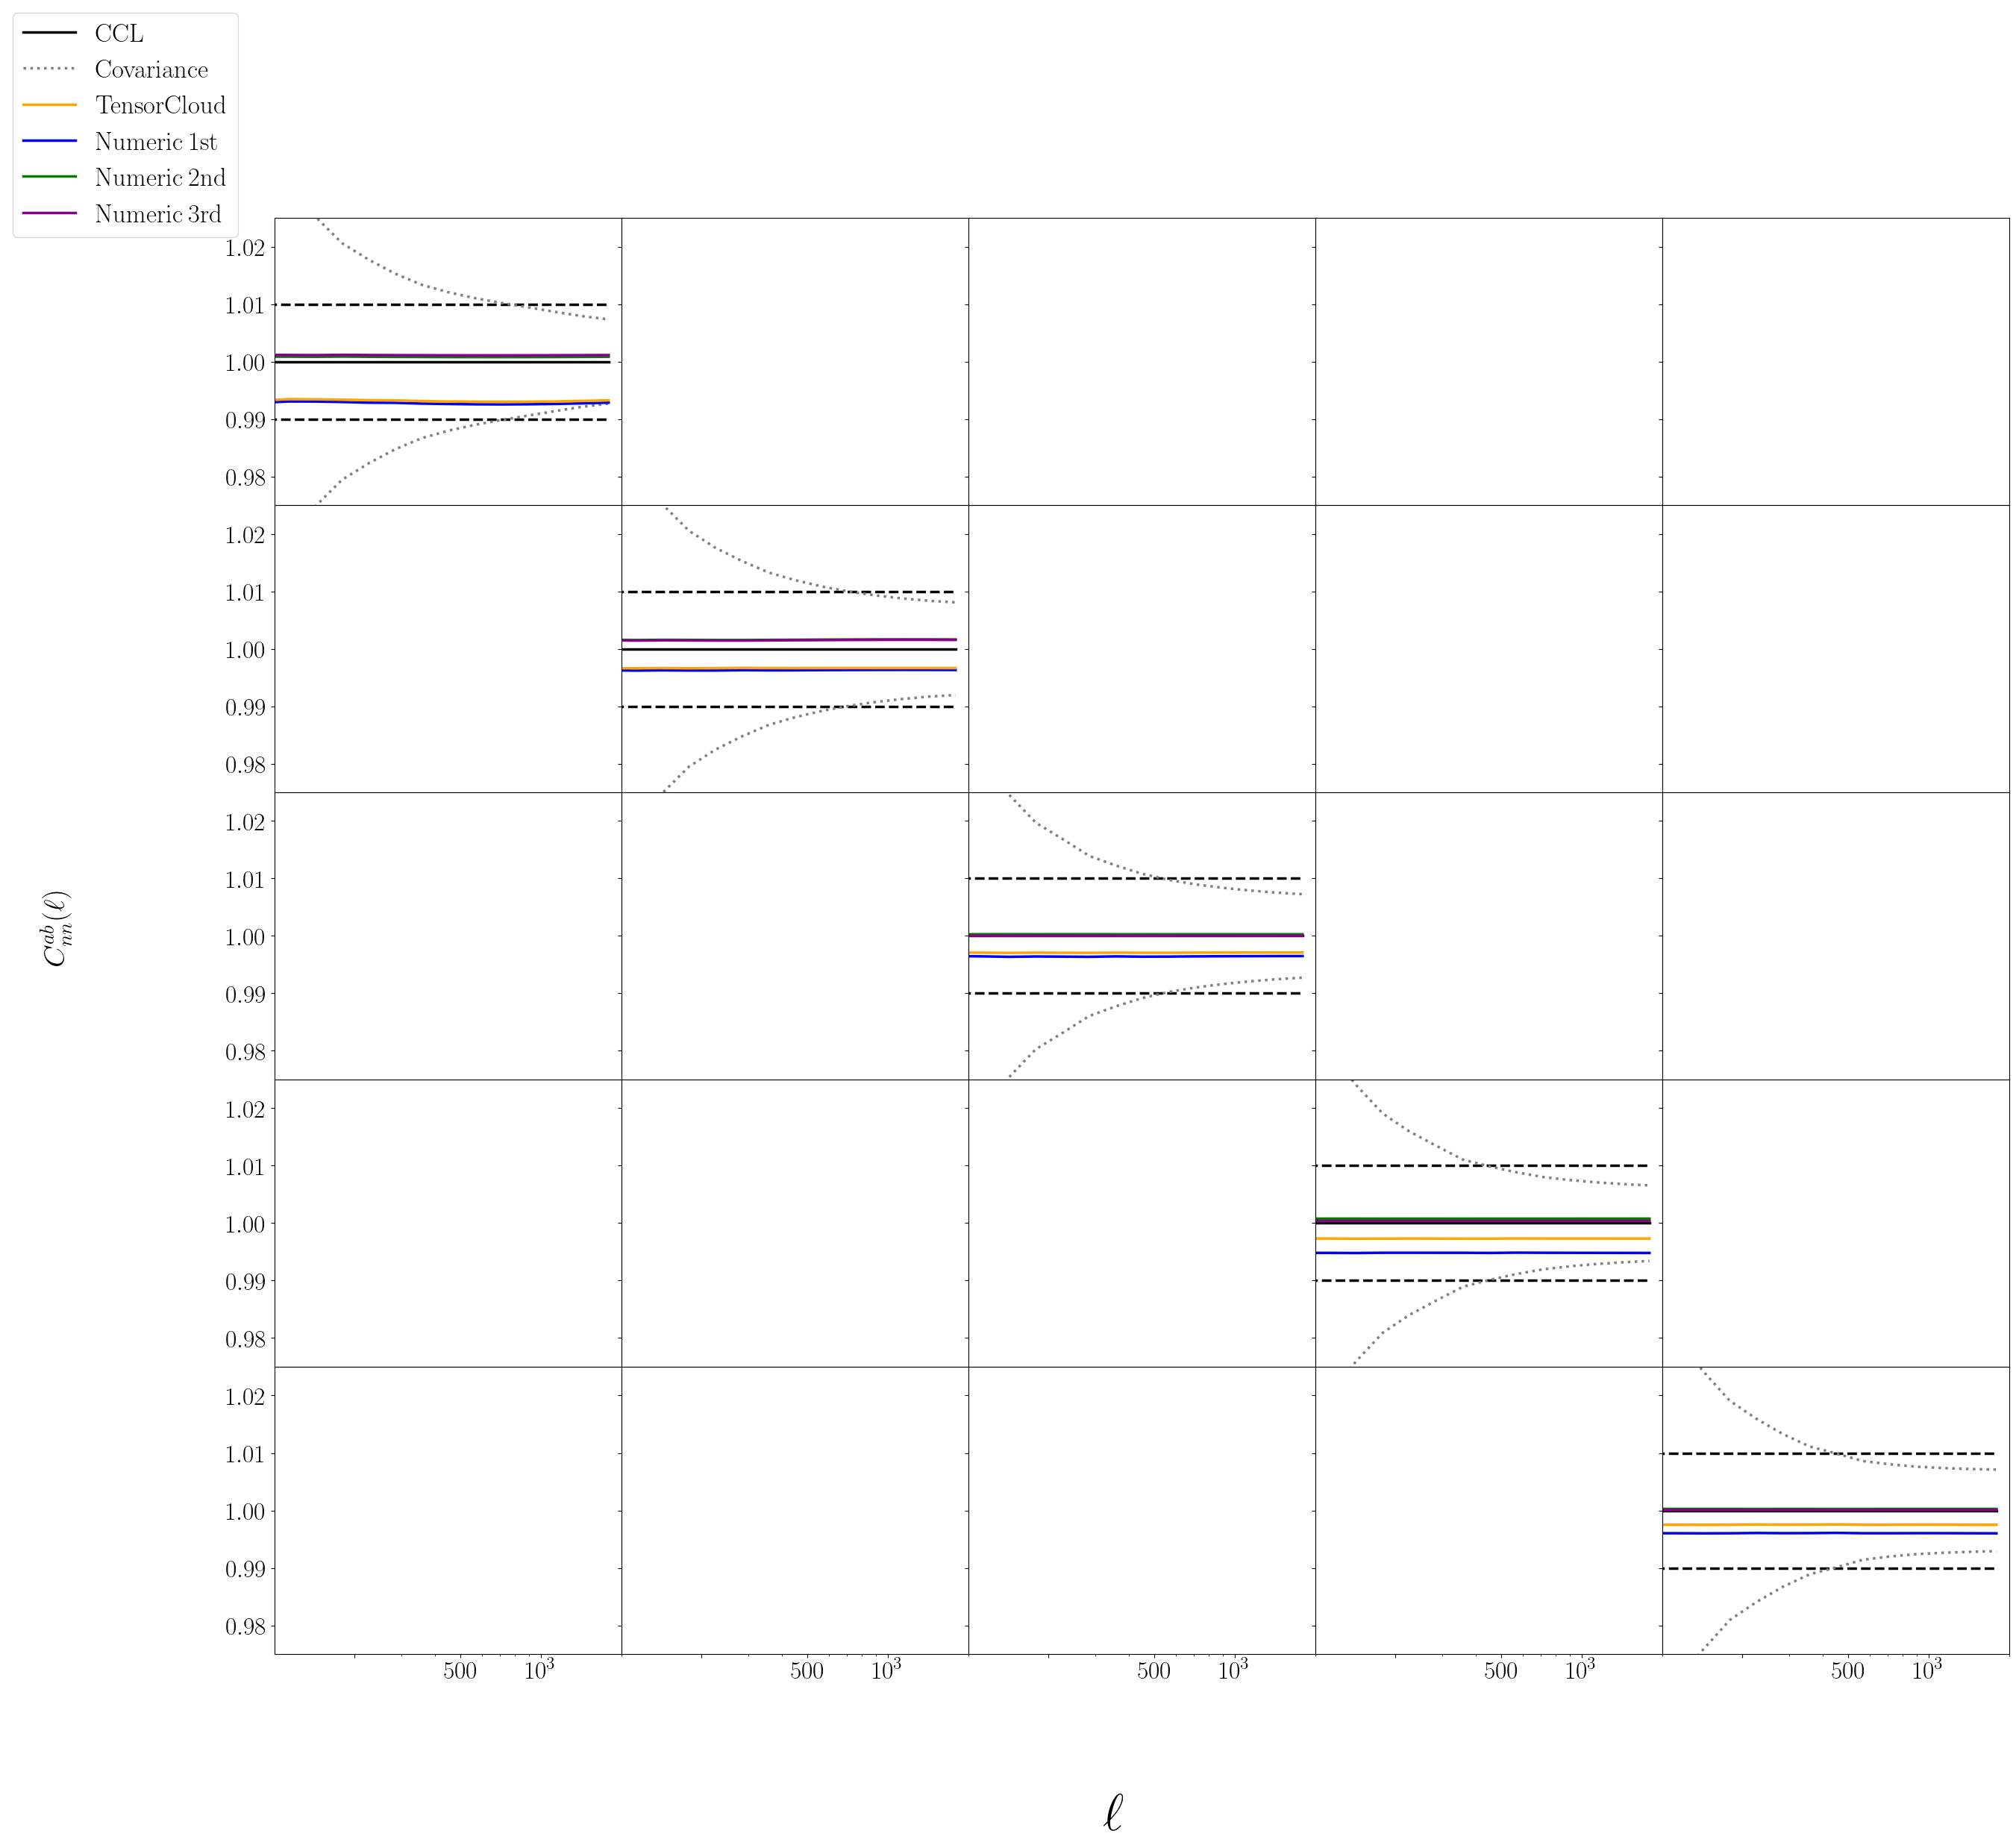

In [20]:
#Compare different bins(After rebinning)

pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_lens_size * 6, bin_lens_size * 5))
GRIDSPEC = GridSpec(5 * bin_lens_size, 6 * bin_lens_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)
for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_lens_size), range(bin_lens_size)):

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    if BIN_INDEX1 == BIN_INDEX2:

        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size), color = 'black', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 + 0.01), color = 'black', linestyle = '--', linewidth = 2.5)
    
        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 - 0.01), color = 'black', linestyle = '--', linewidth = 2.5)

        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)+ sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)
    
        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)- sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)

        PLOT.plot(ell_grid_rebinned, C_RATIO1_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)
    
        PLOT.plot(ell_grid_rebinned, C_RATIO2_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid_rebinned, C_RATIO3_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'darkmagenta', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid_rebinned, C_RATIO_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.975, 1.025)
    PLOT.xaxis.set_major_locator(FixedLocator([200, 500, 1000, 5000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'$200$', r'$500$', r'${10}^3$', r'$5000$']))
    if BIN_INDEX1 < bin_lens_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='grey', linestyle=':', linewidth=2.5, label=r'$\mathrm{Covariance}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='darkmagenta', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
#FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{NN} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C_{nn}^{ab} (\ell)$')

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('Cgg-Y1-cov.png')
FIGURE.show()